In [1]:
# import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes("pastel")
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
from pyspark.sql import SparkSession, Window

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import avg, col, concat, count, desc, asc, explode, lit, split, stddev, udf, isnan, when, rank, from_unixtime

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [4]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("final-project-IT4931") \
    .getOrCreate()

In [7]:
# Read in full sparkify dataset
event_data = "hdfs:///hadoop-master/home/huymac/012019.json"
df = spark.read.json(event_data)

In [8]:
df.head(5)

[Row(_corrupt_record=None, artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1038352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(_corrupt_record=None, artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1038352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(_corrupt_record=None, arti

# Schema information

1. artist: Artist name (ex. Daft Punk)
2. auth: User authentication status (ex. Logged)
3. firstName: User first name (ex. Colin)
4. gender: Gender (ex. F or M)
5. itemInSession: Item count in a session (ex. 52)
6. lastName: User last name (ex. Freeman)
7. length: Length of song (ex. 223.60771)
8. level: User plan (ex. paid)
9. location: User's location (ex. Bakersfield)
10. method: HTTP method (ex. PUT)
11. page: Page name (ex. NextSong)
12. registration: Registration timestamp (unix timestamp) (ex. 1538173362000)
13. sessionId: Session ID (ex. 29)
14. song: Song (ex. Harder Better Faster Stronger)
15. status: HTTP status (ex. 200)
16. ts: Event timestamp(unix timestamp) (ex. 1538352676000)
17. userAgent: User's browswer agent (ex. Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0)
18. userId: User ID (ex. 30)

In [9]:
df.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# I. Thống kê, xử lý số liệu dataset user log 01/2019

In [10]:
df.describe().show()

+-------+--------------------+-----------------+----------+---------+-------+------------------+--------+------------------+-------+----------------+-------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|     _corrupt_record|           artist|      auth|firstName| gender|     itemInSession|lastName|            length|  level|        location| method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+--------------------+-----------------+----------+---------+-------+------------------+--------+------------------+-------+----------------+-------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|                   1|          2301011|   2890514|  2806775|2806775|  

In [11]:
df.describe('artist').show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|          2301011|
|   mean|534.7111617312073|
| stddev|1006.339121913569|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [12]:
df.describe('userId').show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|           2890514|
|   mean| 56696.86281444006|
| stddev|107527.45884121717|
|    min|                  |
|    max|                99|
+-------+------------------+



In [13]:
# Tổng số row
df.count()

2890515

Tất cả các page events trong dataset
- About
- Add Friend
- Add to Playlist
- Cancel
- #### Cancellation Confirmation ####
- Downgrade
- Error
- Help
- Home
- Login
- Logout
- NextSong
- Register
- Roll Advert
- Save Settings
- Settings
- Submit Downgrade
- Submit Registration
- Submit Upgrade
- Thumbs Down
- Thumbs Up
- Upgrade

In [14]:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|                null|
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
+--------------------+
only showing top 20 rows



## Bỏ các dòng bị thiếu giá trị ##

In [26]:
df.filter((isnan(df["artist"])) | (df["artist"].isNull()) | (df["artist"] == "")).count()

589504

In [27]:
df.filter((isnan(df["userId"])) | (df["userId"].isNull()) | (df["userId"] == "")).count()

83740

In [28]:
df.filter((isnan(df["sessionId"])) | (df["sessionId"].isNull()) | (df["sessionId"] == "")).count()

1

In [29]:
df_without_missing_id = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_without_missing_id = df_without_missing_id.filter(df["userId"] != "") # `userId` không thể là string rỗng

In [30]:
print("df:                    {}".format(df.count()))
print("df_without_missing_id: {}".format(df_without_missing_id.count())) # no missing values

if df.count() == df_without_missing_id.count():
    print("No missing values with userId and sessionId")
else:
    print("{} rows have been removed.".format(df.count() - df_without_missing_id.count()))

df:                    2890515
df_without_missing_id: 2806775
83740 rows have been removed.


# II. Phân tích dữ liệu

Phân ra các cột có dữ liệu số, và cột có dữ liệu chuỗi
- num_cols: Long or Double
- cat_cols: String

In [31]:
num_cols = []
cat_cols = []

for s in df.schema:
    data_type = str(s.dataType)
    if data_type == "StringType":
        cat_cols.append(s.name)
    
    if data_type == "LongType" or data_type == "DoubleType":
        num_cols.append(s.name)

In [32]:
num_cols

['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']

In [33]:
cat_cols

['_corrupt_record',
 'artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent',
 'userId']

## Number columns ##

In [34]:
df_without_missing_id.describe(num_cols).show()

+-------+------------------+------------------+--------------------+------------------+------------------+--------------------+
|summary|     itemInSession|            length|        registration|         sessionId|            status|                  ts|
+-------+------------------+------------------+--------------------+------------------+------------------+--------------------+
|  count|           2806775|           2301011|             2806775|           2806775|           2806775|             2806775|
|   mean| 107.7410066713577|248.69113984781708|1.535518616537312...|2005.6354107472098|209.06217812257842|1.258706847907921...|
| stddev|116.89641236727498| 98.48891812803825|3.0787264974172697E9|1407.8004923615572|  30.1064168403456|1.542607590207173...|
|    min|                 0|           0.78322|       1509854193000|                 1|               200|       1038352011000|
|    max|              1005|        3024.66567|       1543073874000|              4808|               40

In [35]:
df_without_missing_id.select("status").dropDuplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



## Category columns ##

In [36]:
df_without_missing_id.select("location").dropDuplicates().show(10)

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|        Richmond, VA|
|          Tucson, AZ|
|       Oskaloosa, IA|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|         Medford, OR|
|Kingsport-Bristol...|
+--------------------+
only showing top 10 rows



In [37]:
df_without_missing_id.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



## Định nghĩa Churn cho data analysis ##

Churn => #Cancellation Confirmation# events
https://data-fun.com/cach-tinh-ty-le-churn-rate-la-gi/

In [38]:
df_without_missing_id.filter("page = 'Cancellation Confirmation'").show(10)

+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|_corrupt_record|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|           null|  null|Cancelled|   Olivia|     F|           40|    Carr|  null| free|      Fort Wayne, IN|   GET|Cancellation Conf...|1536758439000|      490|null|   200|1038400616000|Mozilla/5.0 (Wind...|   208|
|           null|  null|Cancelled|  Lillian|     F|          234| Cameron|  null| paid|        Columbus, OH|   GET|Cancellation Conf...|1533

In [39]:
flag_churned_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_churned = df_without_missing_id.withColumn("churned", flag_churned_event("page"))

### Tính churned rate (trên tổng event logs) ###

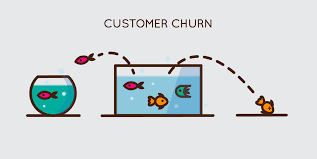

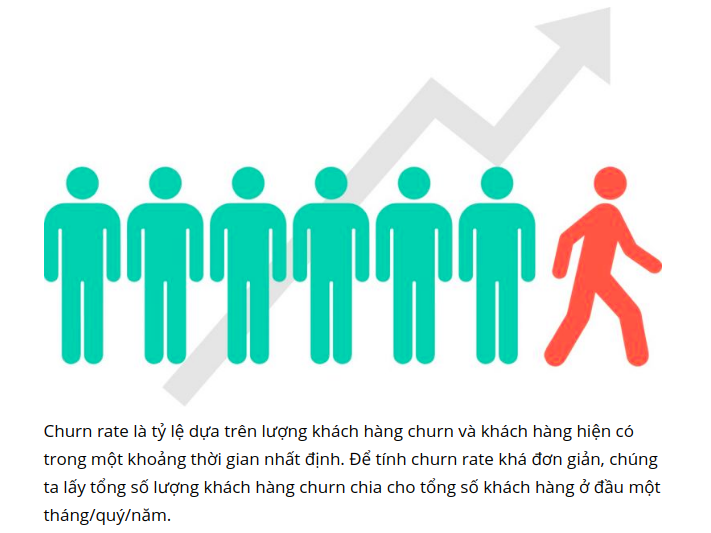

In [61]:
from IPython.display import Image
Image("/home/huymac/churn-rate.png")

In [42]:
churned_rate = df_churned.groupby("userId").agg({"churned": "sum"}).select(avg("sum(churned)")).collect()[0]["avg(sum(churned))"]
print("churned: {:.2f}%".format(churned_rate * 100))

churned: 28.79%


In [45]:
df_churned.select(["userId", "gender", "level", "page", "status", "ts", "churned"]).show(30)

+------+------+-----+---------------+------+-------------+-------+
|userId|gender|level|           page|status|           ts|churned|
+------+------+-----+---------------+------+-------------+-------+
|   293|     M| free|       NextSong|   200|1038352011000|      0|
|    98|     M| free|       NextSong|   200|1038352025000|      0|
|   179|     M| paid|       NextSong|   200|1038352118000|      0|
|   179|     M| paid|         Logout|   307|1038352119000|      0|
|   246|     F| paid|       NextSong|   200|1038352124000|      0|
|   163|     F| paid|       NextSong|   200|1038352125000|      0|
|   179|     M| paid|           Home|   200|1038352176000|      0|
|   175|     F| free|       NextSong|   200|1038352215000|      0|
|   100|     M| free|           Home|   200|1038352241000|      0|
|   100|     M| free|       NextSong|   200|1038352259000|      0|
|   163|     F| paid|       NextSong|   200|1038352263000|      0|
|   246|     F| paid|       NextSong|   200|1038352318000|    

In [46]:
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df_phase = df_churned.withColumn("phase", Fsum('churned').over(windowval))
df_churn = df_phase.withColumn("churn", Fmax('churned').over(Window.partitionBy("userId")))

In [47]:
df_churn.select(["userId", "gender", "level", "page", "status", "ts", "churned", "phase", "churn"]).show(20)

+------+------+-----+-----------+------+-------------+-------+-----+-----+
|userId|gender|level|       page|status|           ts|churned|phase|churn|
+------+------+-----+-----------+------+-------------+-------+-----+-----+
|100010|     F| free|   NextSong|   200|1038991392000|      0|    0|    1|
|100010|     F| free|   NextSong|   200|1038991618000|      0|    0|    1|
|100010|     F| free|   NextSong|   200|1038991903000|      0|    0|    1|
|100010|     F| free|   NextSong|   200|1038992139000|      0|    0|    1|
|100010|     F| free|   NextSong|   200|1038992389000|      0|    0|    1|
|100010|     F| free|   NextSong|   200|1038992616000|      0|    0|    1|
|100010|     F| free|   NextSong|   200|1038992797000|      0|    0|    1|
|100010|     F| free|   NextSong|   200|1038993064000|      0|    0|    1|
|100010|     F| free|Roll Advert|   200|1038993076000|      0|    0|    1|
|100010|     F| free|   NextSong|   200|1038993312000|      0|    0|    1|
|100010|     F| free|   N

In [49]:
churned_user_count = df_churn.filter(df_churn["churn"] == 1).select("userId").dropDuplicates().count()
print("churned user count: {} (total: {})".format(churned_user_count, df_churn.count()))
print("churned user rate: {:.4f}%".format(churned_user_count / df_churn.count() * 100))

churned user count: 99 (total: 2806775)
churned user rate: 0.0035%


# III. Khai phá dữ liệu

Explore Data: So sách giữa 2 nhóm churned users và not churned users
=> Có sự khác biệt nào giữa 2 nhóm này

Các cột sẽ được kiểm tra:
- artist: Số lượng artist
- ### gender: Convert về 0 và 1 ###
- length: Tổng length
- Level: Convert về 0 và 1
- page: 
+ Số lượng Thumbs Up
+ Số lượng Thumbs Down
- song: Số lượng bài hát

#### Convert churn(0 or 1) thành Not Churn or Churn ####
- Cả matplotlib + seaborn đều yêu cầu pandas dataframe(chứ không phải là pyspark dataframe) => Cần convert
//Chuyển đổi từng phần nhỏ dữ liệu (Tránh việc chuyển all dataset -> mất time + lỗi)

In [50]:
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

In [51]:
df_churn_user = df_churn.groupby("userId").max("churn").withColumnRenamed("max(churn)", "churn").select(["userId", "churn"])

##### gender #####

In [52]:
pd_gender = df_churn.select(["userId", "gender", "churn"]).withColumn("churn", func_churn_label("churn")).toPandas()
pd_gender.head()

,userId,gender,churn
0,100010,F,Churn
1,100010,F,Churn
2,100010,F,Churn
3,100010,F,Churn
4,100010,F,Churn


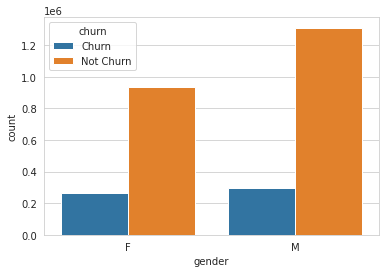

In [53]:
sns.countplot(x="gender", hue="churn", data=pd_gender);

##### level #####

In [54]:
pd_level = df_churn.select(["userId", "level", "churn"]).withColumn("churn", func_churn_label("churn")).toPandas()
pd_level.head()

,userId,level,churn
0,100010,free,Churn
1,100010,free,Churn
2,100010,free,Churn
3,100010,free,Churn
4,100010,free,Churn


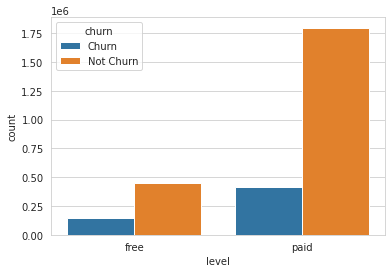

In [55]:
sns.countplot(x="level", hue="churn", data=pd_level);

##### total song #####

In [56]:
pd_song = df_churn_user.join(df_churn.groupby("userId") \
                                     .agg({"song": "count"}) \
                                     .withColumnRenamed("count(song)", "song_count"), ["userId"]) \
                       .withColumn("churn", func_churn_label("churn")).toPandas()
pd_song.head()

,userId,churn,song_count
0,100010,Churn,480
1,200002,Churn,1550
2,296,Churn,672
3,125,Not Churn,368
4,124,Churn,10302


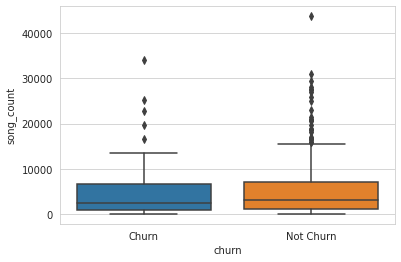

In [57]:
sns.boxplot(x="churn", y="song_count", data=pd_song);

### More info: https://github.com/huymq1710

* Install HDFS and Yarn multi node:  
https://github.com/huymq1710/HDFS-MultiNode

https://medium.com/@jootorres_11979/how-to-set-up-a-hadoop-3-2-1-multi-node-cluster-on-ubuntu-18-04-2-nodes-567ca44a3b12

* Install Spark cluster Yarn mode
https://www.linode.com/docs/databases/hadoop/install-configure-run-spark-on-top-of-hadoop-yarn-cluster/

* Install Zeppelin for Spark, set up for Spark Yarn mode
https://medium.com/@shehanfernando/zeppelin-on-spark-cluster-6732d8eb1b59




![title](https://wompampsupport.azureedge.net/fetchimage?siteId=7575&v=2&jpgQuality=100&width=700&url=https%3A%2F%2Fi.kym-cdn.com%2Fentries%2Ficons%2Ffacebook%2F000%2F019%2F907%2Fmaxresdefault.jpg)